In [1]:
import os,sys
import csv
import copy
import math

from IPython.display import Math
from IPython.display import Latex
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from clawpack import pyclaw

from scipy.integrate import simps, trapz

sys.path.append("/home/pgrover/Dropbox/PhD/Morphodynamic_Model/pymorph")
from weno import WENO,ENO
from weno import get_stencil
from avalanche_scheme import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def get_bed_porosity(D0):
    ''' EQ 12 from Wu, W., Wang, S.S.Y (2007) One-Dimensional Modelling of Dam Break Flow
        over Movable Beds'''
    pm = 0.13 + 0.21/(D0 + 0.002)**0.21
    return pm


nx=500
x = pyclaw.Dimension(0.0,300.0,nx,name='x')
domain = pyclaw.Domain(x)
state = pyclaw.State(domain,1)

 # Set constants 
Base_Bed_Elevation = 5.0
Mean_Water_Depth = 3.0

u_f = 1.0
q_f= u_f*Mean_Water_Depth  

D0 = 1.1
alpha = 1.0

pm = 0.0 #get_bed_porosity(D0)

H = Base_Bed_Elevation + Mean_Water_Depth


# set the intial bed
# Based on eq 21 from Kubatko et al 2007
#state.q[0,:] = np.exp(-beta * (xc-x0)**2) * np.cos(gamma * (xc - x0)) + 10.0
A0 = Base_Bed_Elevation
A1 = 1
lamb = 20.
xc = state.grid.x.centers
dx = state.grid.delta[0]

z = A0 + A1*np.sin( (2.*math.pi*xc)/lamb )
zc = z.copy()

#eq 4
u = q_f/((Mean_Water_Depth+Base_Bed_Elevation) - z)
qbedload = np.zeros(nx)
flux=np.zeros(nx)

# from EQ 5 in Kubatko et al 2007

qbedload = alpha * u


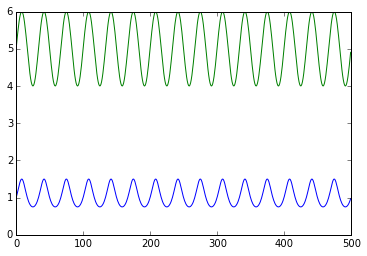

In [3]:
plt.plot(qbedload)
plt.plot(z)

In [5]:


nt = 100   # Number of time steps
dt = 0.1 # Time step size (s)

k = 3 # number of weights Order= 2*k-1

c=1

for n in range(1,nt):  
    zn = zc.copy() 
    for i in range(0,nx): #i=2
        xloc = xc[i-(k-1):i+k] #i+k-1-(i-(k-1)-1) = 2k -1 
        
        qloc = get_stencil(qbedload,i-(k-1),i+k)
        
        qloc_OLD = qbedload[i-(k-1):i+k]
        
        if len(qloc) <5:
            print('Problem qloc={0}  start={1} end={2}, len(qbedload)={3}'.format(qloc,i-(k-1),i+k,len(qbedload)))
        elif len(qloc) >5:
            print('Problem qloc={0}  start={1} end={2}, len(qbedload)={3}'.format(qloc,i-(k-1),i+k,len(qbedload)))

 
        f_left,f_right = WENO(xloc,qloc,k)
        #f_left,f_right = WENO(xloc,uloc,k)
        #upwind flux
        flux[i]=0.5*(c+abs(c))*f_left + 0.5*(c-abs(c))*f_right
        
    # Need the sign of the phase speed
    for i in range(0,nx): #i=2
        if c>0:
            zc[i] = zn[i]-(1./(1.-pm))*dt/dx*(flux[i]-flux[i-1])
        else:
            zc[i] = zn[i]-(1./(1.-pm))*dt/dx*(flux[i+1]-flux[i])
    
    qbedload = alpha * q_f/((Mean_Water_Depth+Base_Bed_Elevation) - zc)

fig = plt.figure(figsize=(16, 4))
ax1 = fig.add_subplot(111)

plt.plot(xc,z,'r')
plt.plot(xc,zc)

IndexError: index 1 is out of bounds for axis 1 with size 0

In [5]:
slopes=np.zeros(len(xc))
for i in range(len(xc)):
    zloc = get_stencil(zc,i,i+2)
    slopes[i] =get_slope(dx, zloc)
print min(slopes)

-17.4163478948


In [45]:
get_stencil(qbedload,-2,3)

First [-0.91174703  9.89638237]
Second: [ 10.10581039   4.46652876   2.00152831]


array([ -0.91174703,   9.89638237,  10.10581039,   4.46652876,   2.00152831])

In [46]:
get_stencil(qbedload,-1,4)

First [ 9.89638237]
Second: [ 10.10581039   4.46652876   2.00152831   2.25298988]


array([  9.89638237,  10.10581039,   4.46652876,   2.00152831,   2.25298988])

In [44]:
qbedload[0:3]

array([ 10.10581039,   4.46652876,   2.00152831])

In [ ]:
gs = np.zeros((nx+2*gc,nt))
flux = np.zeros(nx+2*gc)

for n in range(1,nt):  
    un = uc.copy() 
    for i in range(gc,nx-1+gc): #i=2
        xloc = xc[i-(k-1):i+k] #i+k-1-(i-(k-1)-1) = 2k -1 
        uloc = uc[i-(k-1):i+k]
        f_left,f_right = ENO(xloc,uloc,k)
        #f_left,f_right = WENO(xloc,uloc,k)
        #upwind flux
        flux[i]=0.5*(c+abs(c))*f_left + 0.5*(c-abs(c))*f_right
    # Need the sign of the phase speed
    
    for i in range(gc,nx-gc):
        if c>0:
            uc[i] = un[i]-(1./(1.-pm))dt/dx*(flux[i]-flux[i-1])
        else:
            uc[i] = un[i]-dt/dx*(flux[i+1]-flux[i])
            
    
    